# Nonlinear models

The materials used in this tutorial are based on the applied exercises provided in the book "An Introduction to Statistical Learning with Applications in R" (ISLR). We are trying to demonstrate how to implement the following nonlinear models:
* Polynomial regression
* Regression spline
* Generalized additive model

Even though you will learn how to use the above methods, it still is worth trying by yourself
    1. Section 7.8 in the textbook


## 1. Predict nitrogen oxides concentration in Boston
This question uses the variables <font color="brown">dis</font> (the weighted mean of distances to five Boston employment centers) and <font color="brown">nox</font> (nitrogen oxides concentration in parts per 10 million) from the <font color="brown">Boston</font> data. We will treat <font color="brown">dis</font> as the predictor and <font color="brown">nox</font> as the response.

In [1]:
library(MASS)

### 1.1 Fit a polynomial regression model
Use the <font color="blue">poly()</font> function to fit a cubic polynomial regression to predict <font color="brown">nox</font> using <font color="brown">dis</font>. Report the regression output, and plot the resulting data and polynomial fits. If you are not familiar with the poly() function, remember to use the help() function to print out its usage.

In [2]:
help(poly)

Now, you can follow the lab in section 7.8.1 to fit a simple polynomial regression model with degree 3.

In [3]:
set.seed(1)
poly.fit <- lm(nox ~ poly(dis, 3), data = Boston)
summary(poly.fit)


Call:
lm(formula = nox ~ poly(dis, 3), data = Boston)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.121130 -0.040619 -0.009738  0.023385  0.194904 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.554695   0.002759 201.021  < 2e-16 ***
poly(dis, 3)1 -2.003096   0.062071 -32.271  < 2e-16 ***
poly(dis, 3)2  0.856330   0.062071  13.796  < 2e-16 ***
poly(dis, 3)3 -0.318049   0.062071  -5.124 4.27e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06207 on 502 degrees of freedom
Multiple R-squared:  0.7148,	Adjusted R-squared:  0.7131 
F-statistic: 419.3 on 3 and 502 DF,  p-value: < 2.2e-16


Similar to what we have done with linear regression models, we can diagnose the model by looking at the summary. The p-value indicates that all the polynomial terms are significantly associated with the predictor. In order to see some differences, you can fit a polynomial model with degree 5:

In [4]:
fit_5 <- lm(nox ~ poly(dis, 5), data = Boston)
summary(fit_5)


Call:
lm(formula = nox ~ poly(dis, 5), data = Boston)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.123244 -0.040417 -0.008737  0.024004  0.193135 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.554695   0.002751 201.603  < 2e-16 ***
poly(dis, 5)1 -2.003096   0.061892 -32.365  < 2e-16 ***
poly(dis, 5)2  0.856330   0.061892  13.836  < 2e-16 ***
poly(dis, 5)3 -0.318049   0.061892  -5.139 3.97e-07 ***
poly(dis, 5)4  0.033547   0.061892   0.542   0.5880    
poly(dis, 5)5  0.133009   0.061892   2.149   0.0321 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06189 on 500 degrees of freedom
Multiple R-squared:  0.7175,	Adjusted R-squared:  0.7147 
F-statistic:   254 on 5 and 500 DF,  p-value: < 2.2e-16


You will find that it is still that the first three polynomial terms are significant.

Next, let's plot the fitted curve.

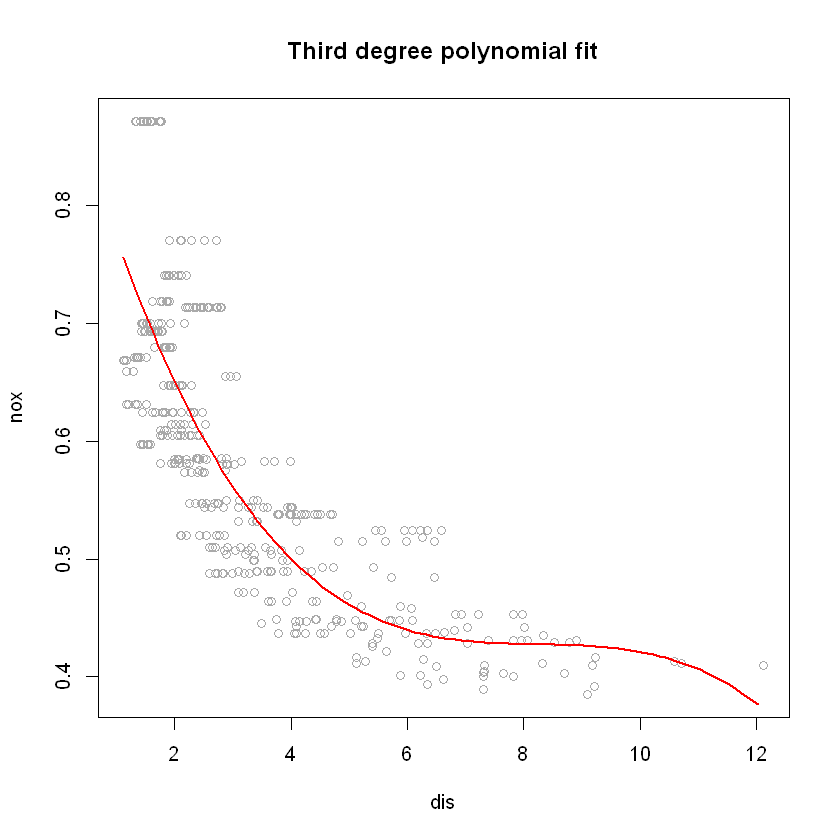

In [5]:
dislims <- range(Boston$dis)
dis.grid <- seq(from = dislims[1], to = dislims[2], by = 0.1)
poly.preds <- predict(poly.fit, list(dis = dis.grid))
plot(nox ~ dis, data = Boston, col = "darkgrey", main='Third degree polynomial fit')
lines(dis.grid, poly.preds, col = "red", lwd = 2)

### 1.2 Compare the polynomial models with different degrees.
Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares. Here you need to generate one figure, where RSS is ploted as a function of polynomial degrees.

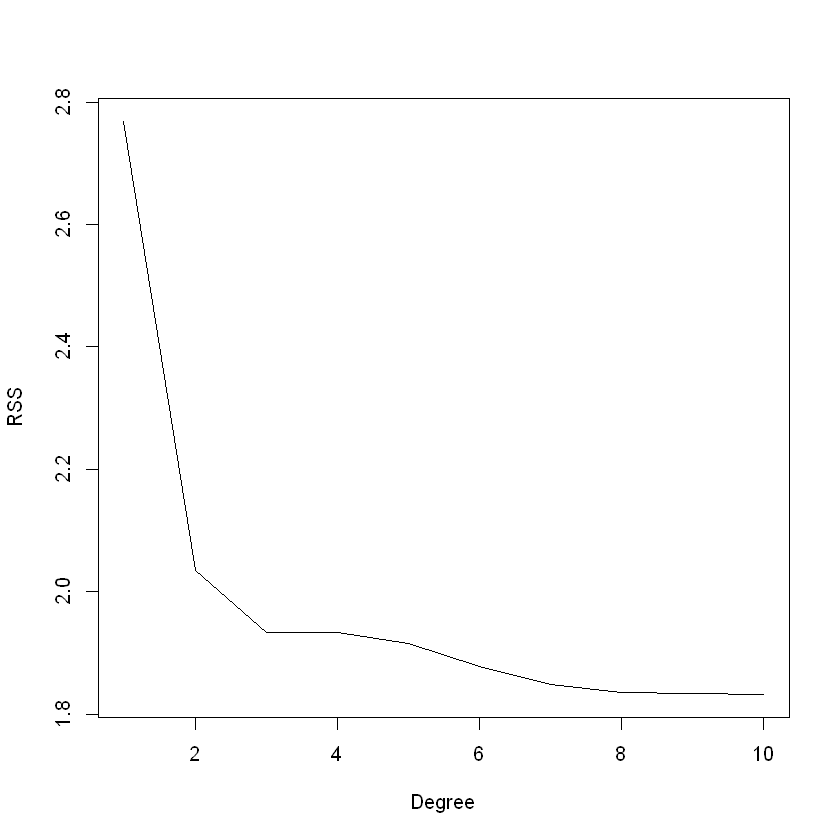

In [6]:
rss <- rep(NA, 10)
for (i in 1:10) {
    fit <- lm(nox ~ poly(dis, i), data = Boston)
    rss[i] <- sum(fit$residuals^2)
}
plot(1:10, rss, xlab = "Degree", ylab = "RSS", type = "l")

### 1.3 Cross-validate the polynomial degree
Perform cross-validation to select the optimal degree for the polynomial, and explain your results. Here, you are going to implement a 10-fold cross validation to pick the best polynomial regression model.

In [3]:
require(splines)
library(ISLR)
library(boot)

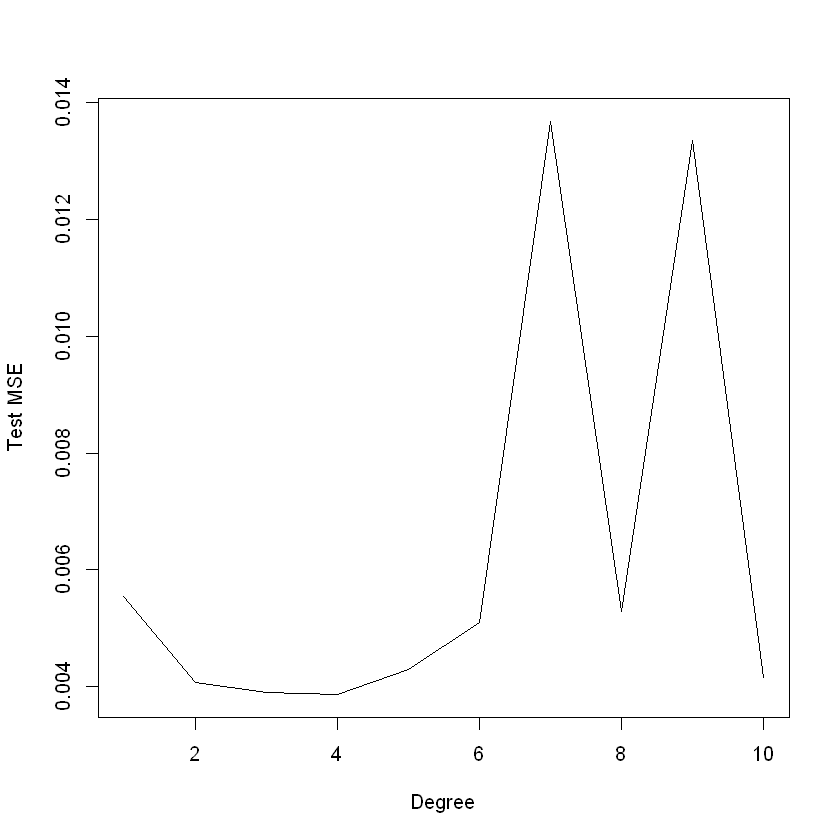

In [8]:
deltas <- rep(NA, 10)
for (i in 1:10) {
    fit <- glm(nox ~ poly(dis, i), data = Boston)
    deltas[i] <- cv.glm(Boston, fit, K = 10)$delta[1]
}
plot(1:10, deltas, xlab = "Degree", ylab = "Test MSE", type = "l")

A 10-fold CV shows that the CV error reduces as we increase degree from 1 to 3, stay almost constant till degree 5, and the starts increasing for higher degrees. We pick 4 as the best polynomial degree.

### 1.4 Fit a regression spline

Use the <font color="blue">bs()</font> function to fit a regression spline to predict <font color="brown">nox</font> using <font color="brown">dis</font>. Report the output for the fit using four degrees of freedom. How did you choose the knots ? Plot the resulting fit. Examples about how to use the <font color="blue">bs()</font> function can be found in section 7.8.2.

We see that <font color="brown">dis</font> has limits of about 1 and 13 respectively. (You can use the summary() function to print out the min, max, mean, median, etc) We split this range in roughly equal 4 intervals and establish knots at $[4, 7, 11]$. Note: bs function in R expects either df or knots argument. If both are specified, knots are ignored.

In [9]:
rs.fit <- lm(nox ~ bs(dis, knots = c(4, 7, 11)), data = Boston)
summary(rs.fit)


Call:
lm(formula = nox ~ bs(dis, knots = c(4, 7, 11)), data = Boston)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.124567 -0.040355 -0.008702  0.024740  0.192920 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.73926    0.01331  55.537  < 2e-16 ***
bs(dis, knots = c(4, 7, 11))1 -0.08861    0.02504  -3.539  0.00044 ***
bs(dis, knots = c(4, 7, 11))2 -0.31341    0.01680 -18.658  < 2e-16 ***
bs(dis, knots = c(4, 7, 11))3 -0.26618    0.03147  -8.459 3.00e-16 ***
bs(dis, knots = c(4, 7, 11))4 -0.39802    0.04647  -8.565  < 2e-16 ***
bs(dis, knots = c(4, 7, 11))5 -0.25681    0.09001  -2.853  0.00451 ** 
bs(dis, knots = c(4, 7, 11))6 -0.32926    0.06327  -5.204 2.85e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06185 on 499 degrees of freedom
Multiple R-squared:  0.7185,	Adjusted R-squared:  0.7151 
F-statistic: 212.3 on 6 and 499 DF,  p-value: <

The summary shows that all terms in spline fit are significant.
Now, we can plot the fitted model.

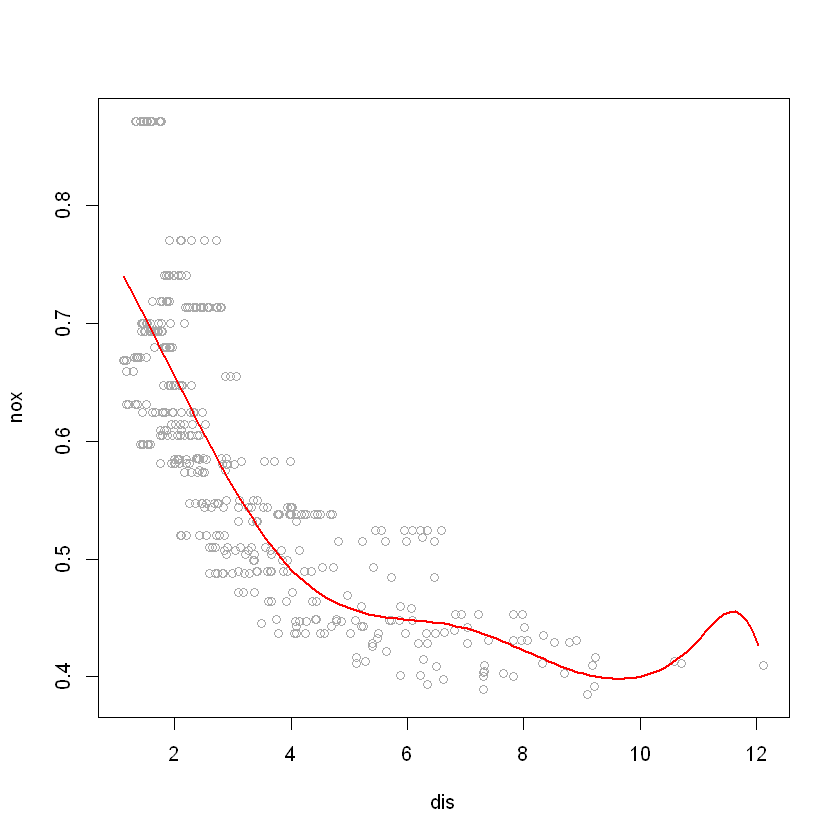

In [10]:
rs.preds <- predict(rs.fit, list(dis = dis.grid))
plot(nox ~ dis, data = Boston, col = "darkgrey")
lines(dis.grid, rs.preds, col = "red", lwd = 2)

Plot shows that the spline fits data well except at the extreme values of $dis$, (especially $dis > 10$).

### 1.5 Fit a set of splines with different degrees of freedom.

Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained. 

We fit regression splines with dfs between 3 and 16.

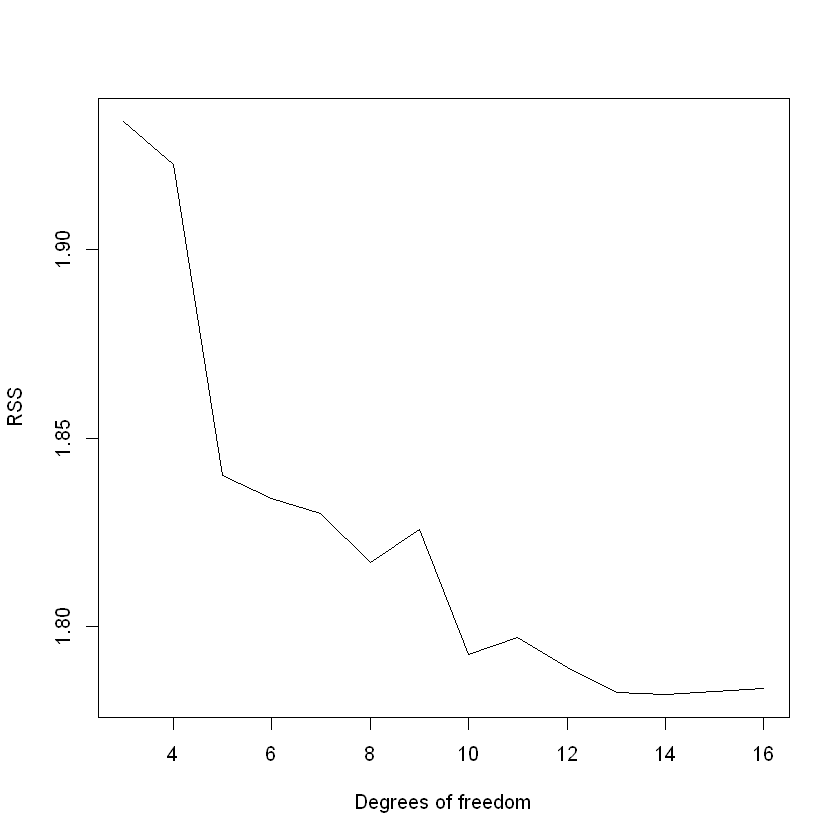

In [11]:
rss <- rep(NA, 16)
for (i in 3:16) {
    fit <- lm(nox ~ bs(dis, df = i), data = Boston)
    rss[i] <- sum(fit$residuals^2)
}
plot(3:16, rss[-c(1, 2)], xlab = "Degrees of freedom", ylab = "RSS", type = "l")

Train RSS monotonically decreases till df=14 and then slightly increases for df=15 and df=16. Now, we need to select the best degree of freedom. 

### 1.6 Cross-validate the degree of freedom in regression spline

Perform cross-validation in order to select the best degrees of freedom for a regression spline on this data. Describe your results. As what we did 1.3, we are going to use 10-fold cross-validation. (Note ignore the warning messages)

In [12]:
cv <- rep(NA, 16)
for (i in 3:16) {
    fit <- glm(nox ~ bs(dis, df = i), data = Boston)
    cv[i] <- cv.glm(Boston, fit, K = 10)$delta[1]
}

Warning message in bs(dis, degree = 3L, knots = numeric(0), Boundary.knots = c(1.1296, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"Warning message in bs(dis, degree = 3L, knots = numeric(0), Boundary.knots = c(1.1296, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"Warning message in bs(dis, degree = 3L, knots = numeric(0), Boundary.knots = c(1.137, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"Warning message in bs(dis, degree = 3L, knots = numeric(0), Boundary.knots = c(1.137, :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"Warning message in bs(dis, degree = 3L, knots = structure(3.0993, .Names = "50%"), :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"Warning message in bs(dis, degree = 3L, knots = structure(3.0993, .Names = "50%"), :
"some 'x' values beyond boundary knots may cause ill-conditioned bases"Warning message in bs(dis, degree = 3L, knots = st

Now, visualize the CV errors by plotting Test MSE against the degree of freedom.

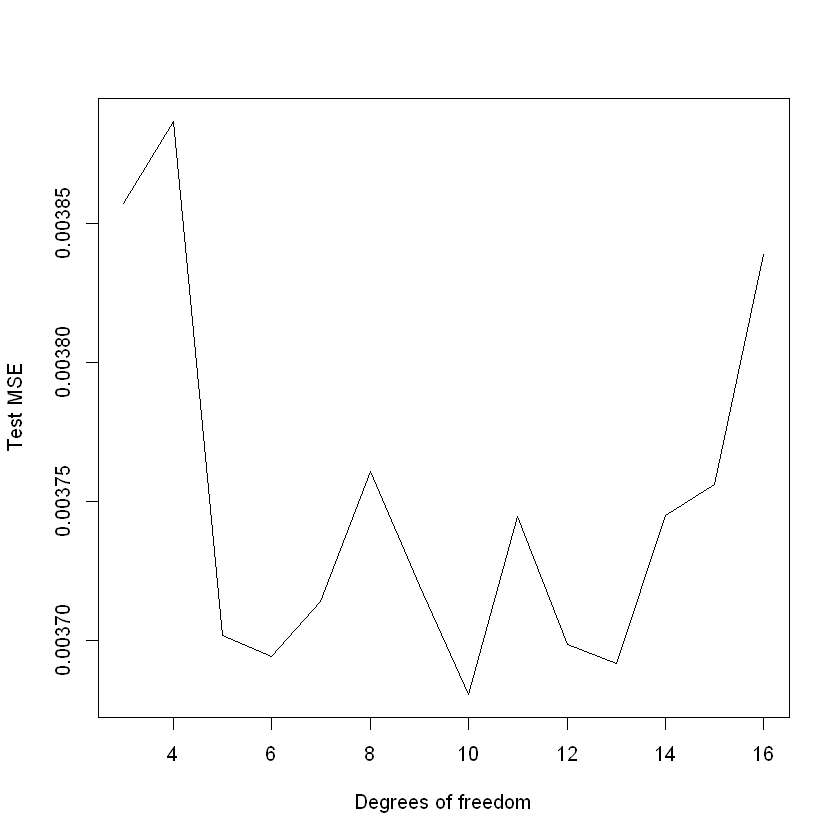

In [13]:
plot(3:16, cv[-c(1, 2)], xlab = "Degrees of freedom", ylab = "Test MSE", type = "l")

CV error is more jumpy in this case, but attains minimum at df=10. We pick $10$ as the optimal degrees of freedom.

## 2 Generalized additive model

In this exercise, we are going to learn how to fit a GAM model to predict the out-of-state tuition on the <font color = "brown">College</font> data set. We start with splitting the data into a training set and a test set.

In [4]:
library(leaps)
set.seed(1)
attach(College)
train <- sample(length(Outstate), length(Outstate) / 2)
test <- -train
College.train <- College[train, ]
College.test <- College[test, ]

ERROR: Error in library(leaps): there is no package called 'leaps'


### 2.1 Perform forward stepwise selection
Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory  model that uses just a subset of the predictors.


In [15]:
fit <- regsubsets(Outstate ~ ., data = College.train, nvmax = 17, method = "forward")
fit.summary <- summary(fit)
fit.summary

Subset selection object
Call: regsubsets.formula(Outstate ~ ., data = College.train, nvmax = 17, 
    method = "forward")
17 Variables  (and intercept)
            Forced in Forced out
PrivateYes      FALSE      FALSE
Apps            FALSE      FALSE
Accept          FALSE      FALSE
Enroll          FALSE      FALSE
Top10perc       FALSE      FALSE
Top25perc       FALSE      FALSE
F.Undergrad     FALSE      FALSE
P.Undergrad     FALSE      FALSE
Room.Board      FALSE      FALSE
Books           FALSE      FALSE
Personal        FALSE      FALSE
PhD             FALSE      FALSE
Terminal        FALSE      FALSE
S.F.Ratio       FALSE      FALSE
perc.alumni     FALSE      FALSE
Expend          FALSE      FALSE
Grad.Rate       FALSE      FALSE
1 subsets of each size up to 17
Selection Algorithm: forward
          PrivateYes Apps Accept Enroll Top10perc Top25perc F.Undergrad
1  ( 1 )  " "        " "  " "    " "    " "       " "       " "        
2  ( 1 )  "*"        " "  " "    " "    " "      

We plot $C_p$, BIC and adjusted-$R^2$ scores in order to identify a satisfactory model.

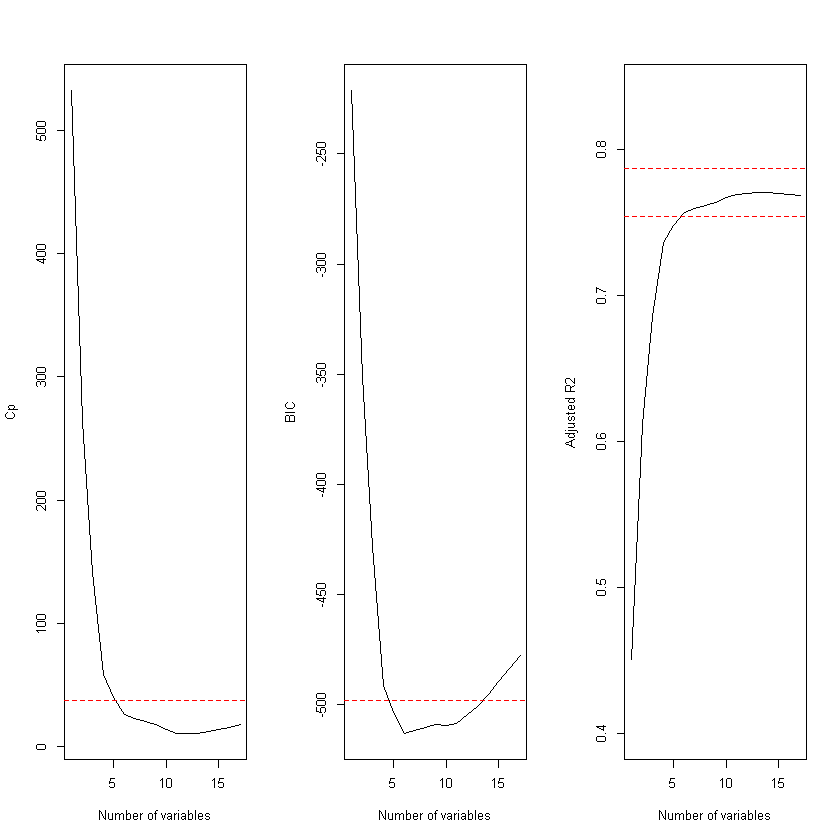

In [16]:
par(mfrow = c(1, 3))
plot(fit.summary$cp, xlab = "Number of variables", ylab = "Cp", type = "l")
min.cp <- min(fit.summary$cp)
std.cp <- sd(fit.summary$cp)
abline(h = min.cp + 0.2 * std.cp, col = "red", lty = 2)
abline(h = min.cp - 0.2 * std.cp, col = "red", lty = 2)
plot(fit.summary$bic, xlab = "Number of variables", ylab = "BIC", type='l')
min.bic <- min(fit.summary$bic)
std.bic <- sd(fit.summary$bic)
abline(h = min.bic + 0.2 * std.bic, col = "red", lty = 2)
abline(h = min.bic - 0.2 * std.bic, col = "red", lty = 2)
plot(fit.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R2", type = "l", ylim = c(0.4, 0.84))
max.adjr2 <- max(fit.summary$adjr2)
std.adjr2 <- sd(fit.summary$adjr2)
abline(h = max.adjr2 + 0.2 * std.adjr2, col = "red", lty = 2)
abline(h = max.adjr2 - 0.2 * std.adjr2, col = "red", lty = 2)

$C_p$, BIC and adjusted-$R^2$ show that size 6 is the minimum size for the subset for which the scores
are within 0.2 standard deviations of optimum. We pick 6 as the best subset size and find best 6 variables using entire data.

In [17]:
fit <- regsubsets(Outstate ~ ., data = College, method = "forward")
coeffs <- coef(fit, id = 6)
names(coeffs)

[1] "(Intercept)" "PrivateYes"  "Room.Board"  "PhD"         "perc.alumni"
[6] "Expend"      "Grad.Rate"

### 2.2 Fit a GAM
Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

In [5]:
require(gam)

Loading required package: gam
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'gam'"

We are going to use smooth spline as the feature function, which can be implemented by using the <font color="blue">s()</font> function in the <font color="brown">gam</font> library.

In [22]:
gam.fit <- gam(Outstate ~ Private + s(Room.Board, df = 2) + s(PhD, df = 2) + s(perc.alumni, df = 2) + s(Expend, df = 5) + s(Grad.Rate, df = 2), data=College.train)

In order to produce similar plots as shown in Figure 7.12 in the textbook, we simply call the <font color="blue">plot()</font> function.

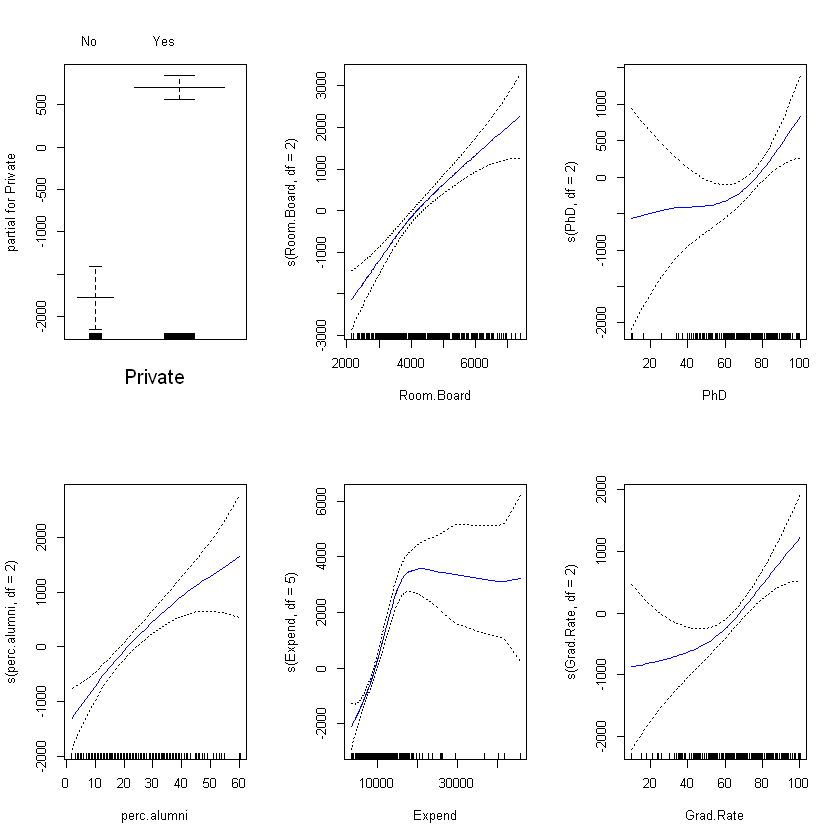

In [24]:
par(mfrow = c(2, 3))
plot(gam.fit, se = T, col = "blue")

### 2.3 Model evaluation

Evaluate the model obtained on the test set, and explain the results obtained.

In [25]:
gam.preds <- predict(gam.fit, College.test)
gam.err <- mean((College.test$Outstate - gam.preds)^2)
gam.err

[1] 3745460

In [26]:
gam.tss = mean((College.test$Outstate - mean(College.test$Outstate))^2)
test.rss = 1 - gam.err/gam.tss
test.rss

[1] 0.7696916

We obtain a test R-squared of 0.77 using GAM with 6 predictors. This is a slight improvement over a test RSS of 0.74 obtained using OLS.

For which variables, if any, is there evidence of a non-linear relationship with the response?

In [27]:
summary(gam.fit)


Call: gam(formula = Outstate ~ Private + s(Room.Board, df = 2) + s(PhD, 
    df = 2) + s(perc.alumni, df = 2) + s(Expend, df = 5) + s(Grad.Rate, 
    df = 2), data = College.train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-4977.74 -1184.52    58.33  1220.04  7688.30 

(Dispersion Parameter for gaussian family taken to be 3300711)

    Null Deviance: 6221998532 on 387 degrees of freedom
Residual Deviance: 1231165118 on 373 degrees of freedom
AIC: 6941.542 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
                        Df     Sum Sq    Mean Sq F value    Pr(>F)    
Private                  1 1779433688 1779433688 539.106 < 2.2e-16 ***
s(Room.Board, df = 2)    1 1221825562 1221825562 370.171 < 2.2e-16 ***
s(PhD, df = 2)           1  382472137  382472137 115.876 < 2.2e-16 ***
s(perc.alumni, df = 2)   1  328493313  328493313  99.522 < 2.2e-16 ***
s(Expend, df = 5)        1  416585875  416585875 126.211 < 2.2e-16 ***
s(Grad.Rate, df = 

Non-parametric Anova test shows a strong evidence of non-linear relationship between response and Expend, and a moderately strong non-linear relationship (using p value of 0.05) between response and Grad.Rate or PhD.